# Scrap Data from web

URL: https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous


In [4]:
from bs4 import BeautifulSoup # documentation available at : www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests # sends http requests and access the page : docs.python-requests.org/en/latest/
import csv # creates the output csv file
#import unicodedata # works with string encoding of the data

entries = []
entry = []
urlnumber = 2 # Give the page number to start with


while urlnumber < 150: # Give the page number to end with

    url = 'https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous/p%d' % (urlnumber,) # Give the url of the forum, excluding the page number in the hyperlink

    try:
        r = requests.get(url, timeout = 10) # Sending a request to access the page
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml') # Getting the page source into the soup
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): # A single post is referred to as a comment. Each comment is a block denoted in a div tag which has a class called comment.
            ps = div.find_all('p') # gets all the tags called p to a variable ps
            aas = div.find_all('a') # gets all the tags called a to a variable aas
            spans = div.find_all('span')
            times = div.find_all('time') # used to extract the time tag which gives the iDate of the post

            concat_str = ''
            for str in aas[1].contents: # prints the contents that is between the tag start and end
                if str != "<br>" or str != "<br/>": # breaks in post which we need to work around
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip() # the format extracted is a unicode - we need a uniform structure to work with the strings
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): # extracting the div tag with the class attribute as message
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) # block quote is used to get the quote made by a person. get_text helps to eliminate the hyperlinks and pulls out only the data.
                        bl.decompose()
                    # Encoding the text to ascii code by replacing the non-ascii characters
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    # Convert the ASCII encoding to Latin1 encoding
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    # Append the encoding bytes to output list
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

# Convert a list of byte to list a of string     
stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
# Save the list to a csv file
with open('edmunds_extraction.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

# Preprocess Data

In [5]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)

## Extract Brand and models


In [6]:
# Define a function to clean the text
def clean_text(text):
    # Replace or remove unwanted characters here
    text = text.replace(',', '').replace('.', '')
    return text.strip().lower()

# Read the csv file into a dataframe
brand_model_data = pd.read_csv('models.csv', header=None)
brand_model_data.columns = ['Brand', 'Model']

# Remove the row where the Brand is 'car'
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'car']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'seat']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'problem']

# Ensure the columns are named correctly
brand_model_data.columns = ['Brand', 'Model']

# Creating a dictionary with the brand as key and a list of unique models as value
brand_model_dict = {}
for index, row in brand_model_data.iterrows():
    # Apply cleaning function to brand and model
    brand = clean_text(row['Brand'])
    model = clean_text(row['Model'])

    if brand in brand_model_dict:
        # Add the model to the brand's list if it's not already there
        if model not in brand_model_dict[brand]:
            brand_model_dict[brand].append(model)
    else:
        brand_model_dict[brand] = [model]

# Formatting the output for better readability with all models
for brand, models in brand_model_dict.items():
    models_list = ", ".join(models)
    print(f"{brand}: {models_list}")

acura: integra, legend, vigor, rlx, ilx, mdx, rdx, tsx, rsx
audi: quattro, a4, a6, a5, a7, q3, q5, q7, a8, a3
bmw: 3-series, 5-series, 6-series, 4-series, xdrive, alpina, 330ci, 328i, 330c, 335i, 335d, 528i, 535i, 128i, 640i, 3er, 5er, m5, m3, m6, bmws, bmwesque
buick: park avenue, la crosse, lacrosse, century, enclave, encore, regal, buicks
cadillac: escalade, srx, xts
chevrolet: grand blazer, trailblazer, silverado, colorado, corvette, suburban, cavalier, caprice, captiva, equinox, express, lacetti, montana, uplander, orlando, tornado, tracker, traverse, camaro, cobalt, impala, lumina, malibu, prisma, tavera, agile, celta, cruze, lanos, omega, optra, sonic, spark, tahoe, aveo, lova, n200, niva, onix, s-10, sail, volt, chevy, malibus
chrysler: town and country, chrysler 300, chrysler 200, pacifica, cruiser, sebring, 300m, lx, chryslers
dodge: challenger, intrepid, avenger, charger, durango, journey, caliber, stealth, magnum, viper, dart, ram
ford: crownvictoria, expedition, supervan, 

## Replace model with brand names, but only count brand onece per comment

In [7]:
# Function to replace model names with brand names in a comment
def replace_models_with_brands(comment, brand_model_dict):
    for brand, models in brand_model_dict.items():
        for model in models:
            if model in comment:
                comment = comment.replace(model, brand)
    return comment

# Function to list unique occurrences of brand names in a comment
def list_unique_brands(comment, brand_model_dict):
    unique_brands = set()
    for brand in brand_model_dict.keys():
        if brand in comment:
            unique_brands.add(brand)
    return ", ".join(unique_brands)

# Load the comments data file
forum_data = pd.read_csv('edmunds_extraction.csv', header=None)

# Clean and lowercase all text in the comments
forum_data.iloc[:, 2] = forum_data.iloc[:, 2].apply(clean_text)

# Apply the function to replace models with brands in each comment
forum_data['Processed Text'] = forum_data.iloc[:, 2].apply(lambda comment: replace_models_with_brands(comment, brand_model_dict))

# Apply the function to list unique brands in each comment
forum_data['Brands Mentioned'] = forum_data['Processed Text'].apply(lambda comment: list_unique_brands(comment, brand_model_dict))

# Display the processed data
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"honda, acura"
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet


## Count Top 10 Brands

In [8]:
from collections import Counter
import pandas as pd

# Combine all brand names into a single list
all_brands = []
for brands in forum_data['Brands Mentioned']:
    # Split the brands and add to the list, skipping empty entries
    all_brands.extend([brand for brand in brands.split(', ') if brand])

# Count the occurrences of each brand
brand_counts = Counter(all_brands)

# Convert the counter to a DataFrame for better readability
brand_counts_df = pd.DataFrame(brand_counts.items(), columns=['Brand', 'Occurrences'])

# Sort the DataFrame by occurrences in descending order
brand_counts_df = brand_counts_df.sort_values(by='Occurrences', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(brand_counts_df)

         Brand  Occurrences
0       toyota         2104
1        honda         1799
2         ford          741
3       nissan          724
4        dodge          657
5          bmw          640
6    chevrolet          563
7        acura          437
8       subaru          397
9   volkswagen          376
10    chrysler          353
11       mazda          301
12        audi          277
13     pontiac          271
14     hyundai          269
15      saturn          251
16       volvo          248
17       sedan          211
18        mini          191
19    mercedes          188
20     lincoln           77
21    cadillac           61
22     mercury           54
23       buick           51
24    infiniti           39
25         kia           35
26      suzuki           26
27  mitsubishi           25


## Tokenize the comment content

In [9]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import string
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

brand_list=set(brand_counts_df["Brand"])

# Step 1: Remove Car Brands
def remove_brands(text, brand_list):
    for brand in brand_list:
        text = text.replace(brand, "")
    return text

# Step 2: Lemmatize Function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

# Step 3: Remove Stop Words and Punctuation, and Filter Single Letters
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = set(stopwords_list.decode().splitlines())
punctuation = set(string.punctuation)

def filter_words(words):
    unique_words = set()  # Initialize an empty set to store unique words
    for word in words:
        if (word not in stop_words 
            and word not in punctuation
            and word not in ["''", "``", "--"]
            and len(word) > 1 
            and not re.search("(n't|'s|'m|'ve|'d|'ll|'re)$", word)
            and not re.fullmatch(r"\.{2,}", word)):
            unique_words.add(word)
    return list(unique_words)


# Step 4: Process and Add to DataFrame
forum_data['Words List'] = forum_data['Processed Text'].apply(lambda x: remove_brands(x, brand_list))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: lemmatize_text(x))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: filter_words(x))

[nltk_data] Downloading package punkt to /Users/kellyliu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kellyliu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kellyliu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned,Words List
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"honda, acura","[drive, area, 34, 05, bay, underpowered, commu..."
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet,"[mpg, highway, v8, 2500, 15, 60, automatic, 4-..."
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[tie, mph, 70, tach, rod, temp, road, coolant,..."
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet,"[school, college, odometer, high, '77, trip, g..."
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[odometer, friend, turn, shade, boat, memory, ..."


## Extract, count, and sort tokenized non-brand words as attributes

In [11]:
attribute_counts = pd.Series([attribute for sublist in forum_data['Words List'] for attribute in sublist]).value_counts()
#print(attribute_counts)

attributes_df = attribute_counts.reset_index()
attributes_df.columns = ['Attribute', 'Count']

attributes_df.head(20)

,Attribute,Count
0,car,3076
1,drive,1633
2,year,1564
3,good,1543
4,buy,1529
5,time,1110
6,mile,1009
7,thing,923
8,nice,840
9,lot,818


# Task A

## Top 10 brands

In [12]:
top_10_brands = brand_counts_df["Brand"].head(10)
print(top_10_brands)

0        toyota
1         honda
2          ford
3        nissan
4         dodge
5           bmw
6     chevrolet
7         acura
8        subaru
9    volkswagen
Name: Brand, dtype: object


In [13]:
# Identify top 10 brands by frequency
brand_counts_df.head(10)

,Brand,Occurrences
0,toyota,2104
1,honda,1799
2,ford,741
3,nissan,724
4,dodge,657
5,bmw,640
6,chevrolet,563
7,acura,437
8,subaru,397
9,volkswagen,376


## MDS Map

Lift Ratios between Brand Pairs:
      Brand 1     Brand 2  Lift Ratio
0      nissan       dodge    2.535802
1        ford   chevrolet    2.341419
2       honda       acura    2.296725
3      subaru  volkswagen    2.181253
4        ford       dodge    2.097622
5       dodge   chevrolet    2.000589
6        ford  volkswagen    1.991989
7   chevrolet      subaru    1.887155
8      nissan   chevrolet    1.797297
9        ford      nissan    1.793157
10      acura      subaru    1.791468
11  chevrolet  volkswagen    1.677941
12        bmw       acura    1.666905
13        bmw  volkswagen    1.660572
14     toyota       dodge    1.595280
15     toyota      nissan    1.583671
16     toyota   chevrolet    1.574266
17     nissan  volkswagen    1.549459
18       ford      subaru    1.534450
19      honda      subaru    1.533458
20      honda      nissan    1.499912
21     toyota        ford    1.495128
22     toyota      subaru    1.488349
23     toyota  volkswagen    1.440519
24      acura  vo

/Users/kellyliu/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/kellyliu/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


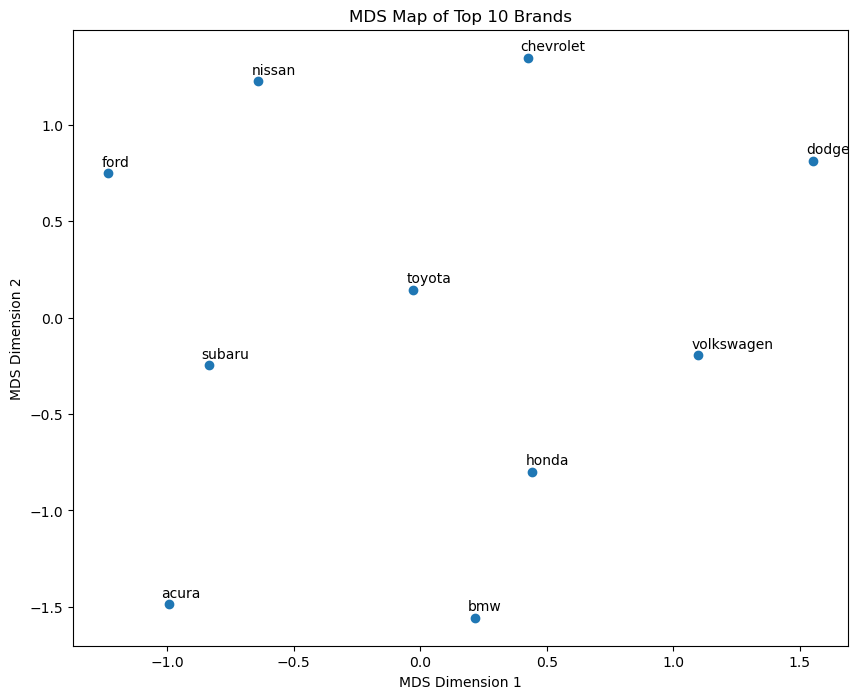

In [14]:
import pandas as pd
from collections import Counter
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Calculate Lift Ratios
def calculate_lift(brand1, brand2, data):
    total_posts = len(data)
    brand1_count = sum(brand1 in brands for brands in data['Brands Mentioned'])
    brand2_count = sum(brand2 in brands for brands in data['Brands Mentioned'])
    both_count = sum(brand1 in brands and brand2 in brands for brands in data['Brands Mentioned'])
    return (total_posts * both_count) / (brand1_count * brand2_count) if brand1_count and brand2_count else 0

lift_matrix = pd.DataFrame(index=top_10_brands, columns=top_10_brands)
lift_ratios = []

# Only calculate lift for unique brand pairs
for i, brand1 in enumerate(top_10_brands):
    for brand2 in top_10_brands[i+1:]:
        lift = calculate_lift(brand1, brand2, forum_data)
        lift_matrix.loc[brand1, brand2] = lift
        lift_matrix.loc[brand2, brand1] = lift  # Symmetric
        lift_ratios.append((brand1, brand2, lift))

# Create a DataFrame for lift ratios
lift_df = pd.DataFrame(lift_ratios, columns=['Brand 1', 'Brand 2', 'Lift Ratio'])
lift_df = lift_df.sort_values(by='Lift Ratio', ascending=False).reset_index(drop=True)

# Display the DataFrame of lift ratios
print("Lift Ratios between Brand Pairs:")
print(lift_df)

# Replace NaN values in the lift matrix with 1 (indicating no lift)
lift_matrix = lift_matrix.fillna(1)

# Multidimensional Scaling (MDS)
mds = MDS(n_components=2, random_state=0)
mds_coords = mds.fit_transform(lift_matrix)

# Plot MDS map
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], marker='o')
for label, x, y in zip(top_10_brands, mds_coords[:, 0], mds_coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-5, 5), textcoords='offset points')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Map of Top 10 Brands')
plt.show()

# Task C

## Top 5 brands selected

In [15]:
top_5_brands = sorted(top_10_brands)[:5]
print(top_5_brands)

['acura', 'bmw', 'chevrolet', 'dodge', 'ford']


## Hand picked top attribute selection

In [16]:
top_100_attributes = attributes_df['Attribute'][0:100]

# Updated list of car-related terms
car_related_terms = [
    'engine', 'transmission', 'brakes', 'suspension', 'steering', 'tires', 'wheels',
    'fuel ', 'safety features', 'price', 'reliability', 'brand', 'design', 'efficiency',
    'comfort', 'interior', 'resale value', 'technology features', 'warranty',"repair","kid","trip","family","road",  
    'maintenance', 'emissions', 'space', 'costs', 'cost',"sound","gas","cheap","price","wheel","power","wagon","acceleration","speed","mileage","mpg","mile"
]

# Initialize an empty dictionary to store ranks and a list for non-car-related terms
car_related_ranks = {}
non_car_related_terms = []

# Iterate over the top_100_attributes list
for rank, attribute in enumerate(top_100_attributes, start=1):
    if attribute in car_related_terms:
        car_related_ranks[attribute] = rank
    else:
        non_car_related_terms.append(attribute)

# car_related_ranks will have the car-related terms and their ranks
# non_car_related_terms will have the attributes that are not car-related
print("Car-related terms and their ranks:", car_related_ranks)
print("Non-car-related terms:", non_car_related_terms)

Car-related terms and their ranks: {'mile': 7, 'price': 11, 'cost': 39, 'mileage': 42, 'wheel': 45, 'gas': 46, 'sound': 47, 'engine': 48, 'interior': 57, 'cheap': 60, 'warranty': 65, 'kid': 66, 'power': 77, 'wagon': 78, 'road': 82, 'repair': 91, 'mpg': 98}
Non-car-related terms: ['car', 'drive', 'year', 'good', 'buy', 'time', 'thing', 'nice', 'lot', 'dealer', 'sell', 'work', 'pretty', 'pay', 'vehicle', 'month', 'great', 'big', 'deal', 'day', 'truck', 'bad', 'trade', 'long', 'seat', 'wife', 'guess', 'start', 'problem', 'model', 'people', 'love', 'money', 'week', 'couple', 'bit', 'lease', 'ago', 'tire', 'guy', 'check', 'high', 'stick', 'kind', 'small', 'hard', 'low', 'leave', 'today', 'turn', 'change', 'figure', 'fun', 'replace', 'yeah', 'offer', 'feel', 'worth', 'live', 'close', 'sit', 'issue', 'talk', 'door', 'pick', 'reason', 'payment', 'fit', 'driver', 'idea', 'friend', 'house', 'point', 'spend', 'wait', 'auto', 'real', 'hear', 'expensive', 'rear', 'stuff', 'purchase', 'option']


## Top 5 car attributes co-occurred with the 5 brands

In [17]:
top_5_attributes = sorted(car_related_ranks, key=car_related_ranks.get)[:5]

print(top_5_attributes)


['mile', 'price', 'cost', 'mileage', 'wheel']


In [18]:

# Initialize dictionaries to store counts
brand_counts = {brand: 0 for brand in top_5_brands}
attribute_counts = {attribute: 0 for attribute in top_5_attributes}
co_occurrence_counts = {(brand, attribute): 0 for brand in top_5_brands for attribute in top_5_attributes}

# Count the occurrences and co-occurrences
for _, row in forum_data.iterrows():
    brands_mentioned = row['Brands Mentioned']
    words_list = row['Words List']
    
    for brand in top_5_brands:
        if brand in brands_mentioned:
            brand_counts[brand] += 1
            for attribute in top_5_attributes:
                if attribute in words_list:
                    co_occurrence_counts[(brand, attribute)] += 1

    for attribute in top_5_attributes:
        if attribute in words_list:
            attribute_counts[attribute] += 1

# Total number of rows
total_rows = len(forum_data)

# Prepare a list to store the results
lift_data = []

# Calculate lift for each brand-attribute pair
for brand in top_5_brands:
    for attribute in top_5_attributes:
        p_a = brand_counts[brand] / total_rows
        p_b = attribute_counts[attribute] / total_rows
        p_a_and_b = co_occurrence_counts[(brand, attribute)] / total_rows
        lift = p_a_and_b / (p_a * p_b)
        lift_data.append({"Brand": brand, "Attribute": attribute, "Lift": lift})

# Convert the list to a DataFrame
lift_df = pd.DataFrame(lift_data)
lift_df = lift_df.sort_values(by=["Brand", "Lift"], ascending=[True, False])

# Display the DataFrame
# print(lift_df)
lift_df.head(30)

,Brand,Attribute,Lift
4,acura,wheel,1.661065
1,acura,price,1.579880
3,acura,mileage,1.295714
0,acura,mile,1.107651
2,acura,cost,1.096738
7,bmw,cost,1.917098
6,bmw,price,1.625739
5,bmw,mile,1.375124
8,bmw,mileage,1.281332
9,bmw,wheel,1.228713


# Task E

- Need to find what attributes consider as indicators of "aspiration" in the context of automotive brands. 

Run sentiment analysis on every
1. entire post content
2. every top 5 attributes

Run regression of whole vs. attributes

In [19]:
forum_data.head(10)

,0,1,2,Processed Text,Brands Mentioned,Words List
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"honda, acura","[drive, area, 34, 05, bay, underpowered, commu..."
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet,"[mpg, highway, v8, 2500, 15, 60, automatic, 4-..."
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[tie, mph, 70, tach, rod, temp, road, coolant,..."
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet,"[school, college, odometer, high, '77, trip, g..."
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[odometer, friend, turn, shade, boat, memory, ..."
5,andre1969,September 2005,that impala has a 256:1 rear end if you go to ...,that chevrolet has a 256:1 rear end if you go ...,"chevrolet, chrysler, toyota, subaru","[happen, '79-81, standard, mile, minute, nosta..."
6,ghulet,September 2005,what engine does your chevy have (btw is it a ...,what engine does your chevrolet have (btw is i...,"cadillac, chevrolet, buick, honda, lincoln","[tilt, 15, engine, '71, electra, trim, felt, l..."
7,boomchek,September 2005,i think it has a 305 v8 i personally don't kno...,i think it has a 305 v8 i personally don't kno...,"honda, chevrolet","[immature, previous, tilt, gulp, impress, odom..."
8,andre1969,September 2005,if it's an impala or a caprice is whether or n...,if it's an chevrolet or a chevrolet is whether...,"ford, chevrolet, toyota, dodge","[350, thick, 2-ls, drive, '77-85, engine, chan..."
9,ghulet,September 2005,the mustang 50s of the time only had about 150...,the ford 50s of the time only had about 150hp ...,"ford, chevrolet, mercury, hyundai","[350, jealous, unfavorably, money, parent, mom..."


In [20]:
forum_data['Processed Text']

0       acura v hondaexactly the same choice i went th...
1       my chevrolet 2500 turns about 2k @ 70mph 60 v8...
2       i got my 78 chevrolet back on the road today a...
3       i had a '77 chevrolet when i was in high schoo...
4       oh you can enjoy and relive all those memories...
                              ...                        
7395    since i can't imagine that a dipstick was a su...
7396    after seeing more and more new honda and toyot...
7397    bmw is supposedly making a couple of their die...
7398    bmw is supposedly making a couple of their die...
7399    i love the look of the current 5 series otoh i...
Name: Processed Text, Length: 7400, dtype: object

### Filter for the post related to buy/own activities

In [21]:
# List of keywords to filter on
buy_keywords = [
    "Acquire", "Procure", "Obtain", "Invest", "Shop", "Pick", "Secure", "Buy", "Take", 
    "Possess", "Hold", "Have", "Retain", "Keep", "Maintain", "Control", "Lease", 
    "Hire", "Charter", "Borrow", "Sublease", "Book"
]

# Function to check if any keyword is in the text
def contains_keyword(text):
    return any(keyword.lower() in text.lower() for keyword in buy_keywords)

# Apply the function to the 'Processed Text' column to create a mask
mask = forum_data['Processed Text'].apply(contains_keyword)

# Filter the DataFrame using the mask
forum_data = forum_data[mask]

forum_data.shape

(4707, 6)

#### Add serial number

In [22]:
import pandas as pd

# Assuming forum_data is already loaded and is your DataFrame

# Reset the index to get a new serial number column starting from 0
forum_data.reset_index(drop=True, inplace=True)

# Insert the index column at the first position (position 0) with the label 'Serial Number'
forum_data.insert(0, 'Serial Number', forum_data.index)

forum_data.head()

,Serial Number,0,1,2,Processed Text,Brands Mentioned,Words List
0,0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"honda, acura","[drive, area, 34, 05, bay, underpowered, commu..."
1,1,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[tie, mph, 70, tach, rod, temp, road, coolant,..."
2,2,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[odometer, friend, turn, shade, boat, memory, ..."
3,3,andre1969,September 2005,that impala has a 256:1 rear end if you go to ...,that chevrolet has a 256:1 rear end if you go ...,"chevrolet, chrysler, toyota, subaru","[happen, '79-81, standard, mile, minute, nosta..."
4,4,ghulet,September 2005,what engine does your chevy have (btw is it a ...,what engine does your chevrolet have (btw is i...,"cadillac, chevrolet, buick, honda, lincoln","[tilt, 15, engine, '71, electra, trim, felt, l..."


### Sentiment analysis on filtered posts

In [23]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

analyzer = SentimentIntensityAnalyzer()

processed_text_list_filtered = forum_data['Processed Text'].tolist()

# Initialize an empty list to store posts and their detailed sentiment scores
posts_and_scores_filtered = []

for post in processed_text_list_filtered:
    vs = analyzer.polarity_scores(post)

    # Append a tuple with the post and its sentiment scores
    posts_and_scores_filtered.append((post, vs['neg'], vs['neu'], vs['pos'], vs['compound']))

# Convert the list to a DataFrame for better visualization
post_sentiment_filtered_df = pd.DataFrame(posts_and_scores_filtered, columns=['Post', 'Negative', 'Neutral', 'Positive', 'Compound'])
#post_sentiment_filtered_df.head(10)

# Concatenate the sentiment DataFrame with the original filtered_data DataFrame
filtered_data_with_sentiments = pd.concat([forum_data, post_sentiment_filtered_df], axis=1)
filtered_data_with_sentiments.shape
#filtered_data_with_sentiments.to_csv('filtered_data_with_sentiments.csv')

(4707, 12)

In [24]:
filtered_data_with_sentiments.head()

,Serial Number,0,1,2,Processed Text,Brands Mentioned,Words List,Post,Negative,Neutral,Positive,Compound
0,0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"honda, acura","[drive, area, 34, 05, bay, underpowered, commu...",acura v hondaexactly the same choice i went th...,0.000,0.916,0.084,0.8398
1,1,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[tie, mph, 70, tach, rod, temp, road, coolant,...",i got my 78 chevrolet back on the road today a...,0.000,1.000,0.000,0.0000
2,2,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[odometer, friend, turn, shade, boat, memory, ...",oh you can enjoy and relive all those memories...,0.017,0.847,0.136,0.8442
3,3,andre1969,September 2005,that impala has a 256:1 rear end if you go to ...,that chevrolet has a 256:1 rear end if you go ...,"chevrolet, chrysler, toyota, subaru","[happen, '79-81, standard, mile, minute, nosta...",that chevrolet has a 256:1 rear end if you go ...,0.000,0.958,0.042,0.7717
4,4,ghulet,September 2005,what engine does your chevy have (btw is it a ...,what engine does your chevrolet have (btw is i...,"cadillac, chevrolet, buick, honda, lincoln","[tilt, 15, engine, '71, electra, trim, felt, l...",what engine does your chevrolet have (btw is i...,0.013,0.950,0.038,0.7119


### Sentiment per brand

In [25]:
# Expand the 'Brands Mentioned' column into a list of brands
# This assumes that brands in 'Brands Mentioned' column are separated by commas
expanded_brands = filtered_data_with_sentiments['Brands Mentioned'].str.split(', ', expand=True)

# Melt the expanded brands back into a single column while keeping the index for joining with sentiment scores
melted_brands = expanded_brands.melt(ignore_index=False).dropna()

# Remove the 'variable' column and rename the 'value' column to 'Brand'
melted_brands = melted_brands.drop('variable', axis=1).rename(columns={'value': 'Brand'})

# Join the melted brands with the sentiment scores from filtered_data_with_sentiments DataFrame
brand_sentiments = melted_brands.join(filtered_data_with_sentiments['Compound'])
#brand_sentiments.shape
#brand_sentiments.head(10)

# Now we group by the brand and calculate the average compound sentiment score per unique brand
average_brand_sentiment = brand_sentiments.groupby('Brand')['Compound'].mean().reset_index()

average_brand_sentiment=average_brand_sentiment.sort_values(by='Compound', ascending=False)
average_brand_sentiment.head(30)



,Brand,Compound
19,mitsubishi,0.766033
12,infiniti,0.656517
23,sedan,0.608644
14,lincoln,0.603593
22,saturn,0.597028
4,buick,0.595982
5,cadillac,0.591344
11,hyundai,0.589380
15,mazda,0.585144
17,mercury,0.578386


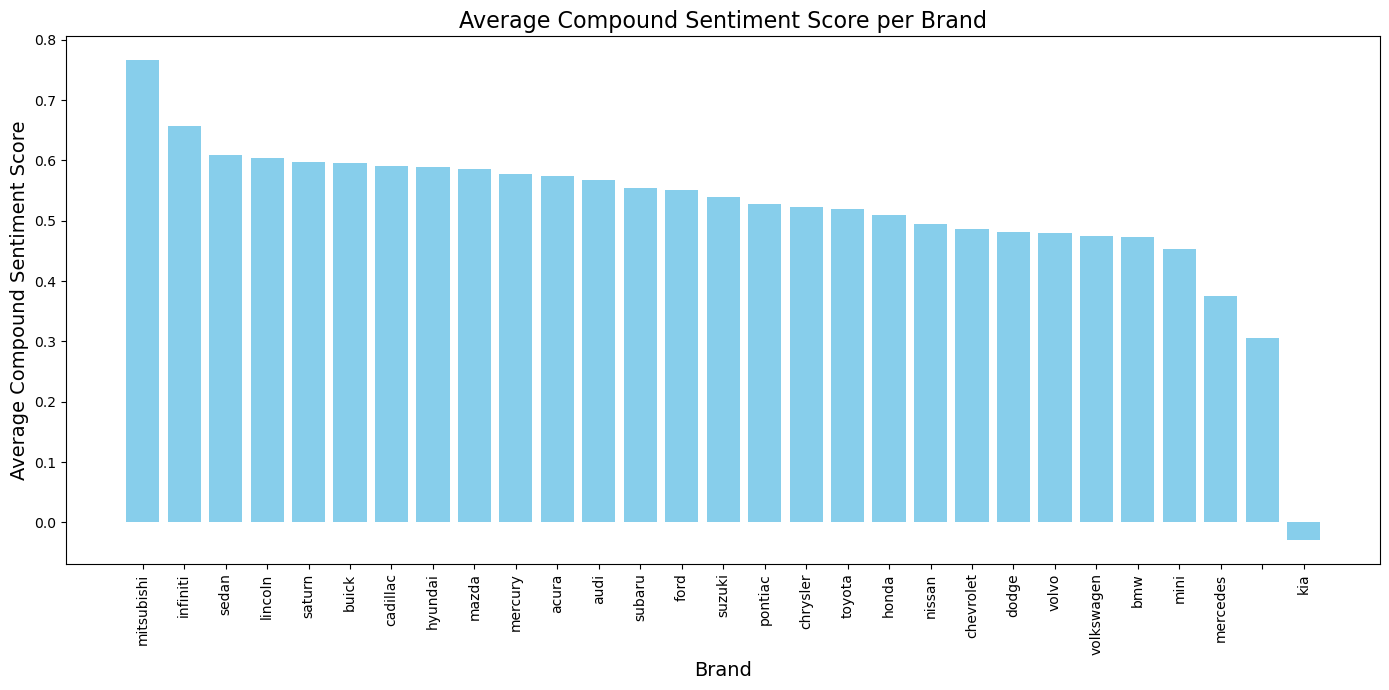

In [26]:
# Plotting the average compound sentiment score for each brand
plt.figure(figsize=(14, 7))
plt.bar(average_brand_sentiment['Brand'], average_brand_sentiment['Compound'], color='skyblue')
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Average Compound Sentiment Score', fontsize=14)
plt.xticks(rotation=90)
plt.title('Average Compound Sentiment Score per Brand', fontsize=16)
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()